In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
from main import COCODataset

In [2]:
ds = COCODataset('data/train', 'data/annotations.json')
ds.lenc.classes_

array(['apple', 'banana', 'bowl', 'broccoli', 'carrot', 'cup',
       'dining table', 'knife'], dtype=object)

In [3]:
# Which are the most prevalent classes?

In [4]:
counts = []
for _, ann in ds:
    counts.extend(ds.lenc.inverse_transform(ann['labels']).tolist())

<AxesSubplot:>

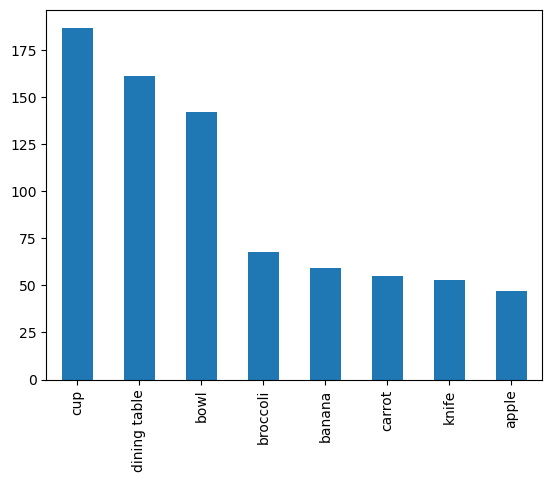

In [5]:
counts = pd.Series(counts)
counts.value_counts().plot(kind='bar')

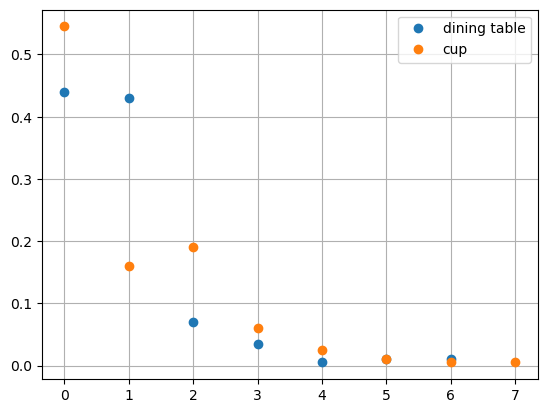

In [35]:
# RV X - number of dining tables per image, Y - number of cups per image
X = []
Y = []
ids = []
for _, ann in ds:
    labels = ds.lenc.inverse_transform(ann['labels'])
    X.append((labels == 'dining table').sum())
    Y.append((labels == 'cup').sum())
    ids.append(ann['id'].item())
df = pd.DataFrame.from_dict({'id': ids, 'n_cups': Y, 'n_dt': X})

ax = df['n_dt'].value_counts(normalize=True).sort_index().plot(marker='o', ls='', label='dining table')
df['n_cups'].value_counts(normalize=True).sort_index().plot(ax=ax, marker='o', ls='', label='cup')
plt.grid()
plt.legend()

In [38]:
import seaborn as sns

In [99]:
df

,id,n_cups,n_dt
0,1307,0,0
1,1355,1,0
2,3579,3,0
3,4579,0,0
4,10303,0,1
...,...,...,...
195,572602,0,1
196,576771,0,2
197,577160,1,1
198,577725,2,3


<AxesSubplot:xlabel='n_dt', ylabel='n_cups'>

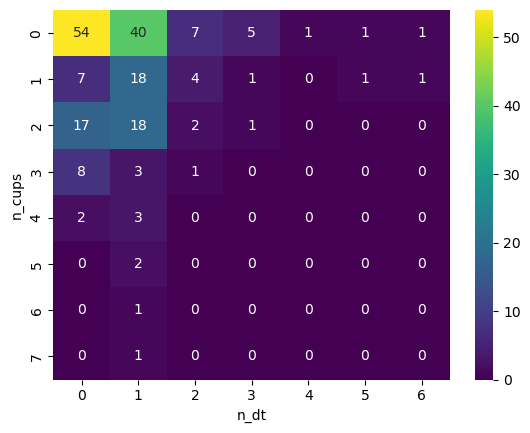

In [42]:
ct = pd.crosstab(index=df['n_cups'], columns=df['n_dt'])
sns.heatmap(ct, annot=True, cmap=plt.cm.viridis)

In [45]:
# Clsutering by labels

from sklearn import cluster
from sklearn.feature_extraction.text import CountVectorizer

docs = []
ids = []
for img, ann in ds:
    labels = [k.replace(' ', '_') for k in ds.lenc.inverse_transform(ann['labels'])]
    docs.append(' '.join(labels))
    ids.append(ann['id'].item())

In [47]:
cv = CountVectorizer()
x = cv.fit_transform(docs)

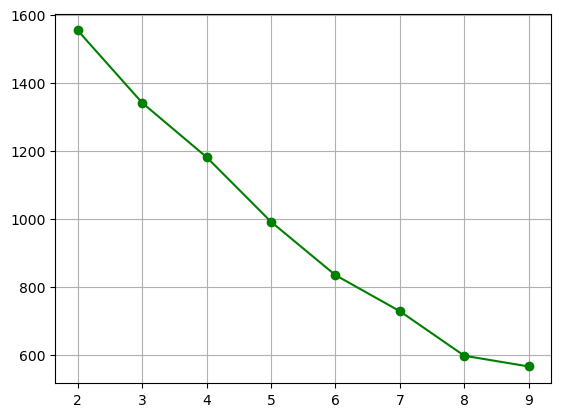

In [54]:
inertia = []
clusters = np.arange(2, 10)

for n_clus in clusters:
    km = cluster.KMeans(n_clusters=n_clus).fit(x)
    inertia.append(km.inertia_)
    
plt.plot(clusters, inertia, 'go-')
plt.grid()

In [56]:
cluster_labels = cluster.KMeans().fit(x).labels_

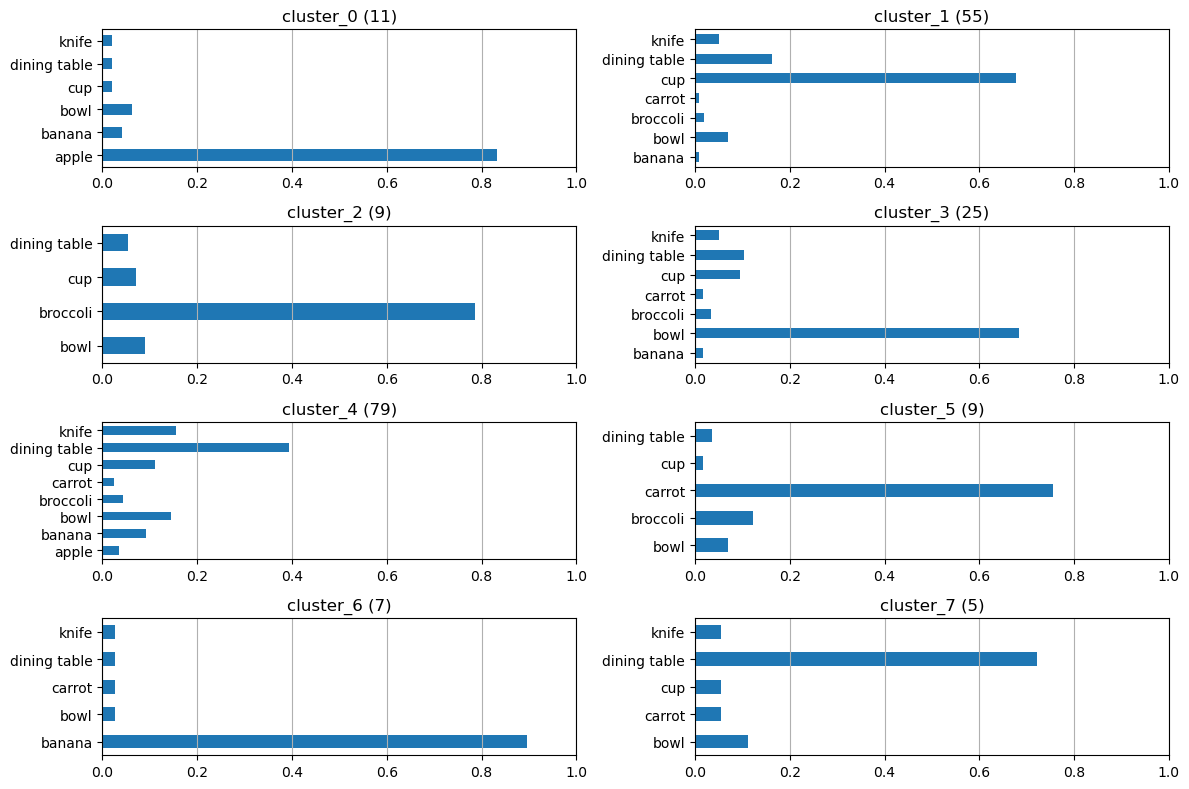

In [78]:
ids = np.array(ids)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))


for i, _ax in zip(range(8), ax.ravel()):
    ix = ids[cluster_labels == i]
    labelcount = []
    for img in ix:
        ann = ds.get_mask(img)
        labels = [k[0] for k in ann]
        labelcount.extend(ds.lenc.inverse_transform(labels).tolist())
    ax = pd.Series(labelcount).value_counts(normalize=True).sort_index().plot(kind='barh', ax=_ax)
    ax.set_title(f'cluster_{i} ({ix.shape[0]})')
    ax.grid(axis='x')
    ax.set_xlim(0, 1)
plt.tight_layout()

In [93]:
ix = ids[cluster_labels == 7]

In [98]:
ds.get_mask(ix[2])

[(6, 0.96, 102.62, 631.9000000000001, 420.97),
 (6, 495.36, 58.58, 640.0, 205.75),
 (6, 325.82, 32.68, 401.95, 112.68),
 (7, 0.0, 298.16, 109.64, 355.87),
 (4, 294.03, 246.71, 427.51, 400.73),
 (4, 275.77, 296.1, 296.91999999999996, 311.38),
 (6, 598.03, 50.43, 640.0, 69.38)]

In [96]:
ds.lenc.classes_

array(['apple', 'banana', 'bowl', 'broccoli', 'carrot', 'cup',
       'dining table', 'knife'], dtype=object)

In [15]:
n = 200                                    # trials
k = 7                                      # Different possible outcomes 
p = X.value_counts(normalize=True).values  # probabilities

In [16]:
# Draw 120 samples. What is the probability that the number of DTs is as follows?
X.value_counts().sort_index() * 0.6

0    52.8
1    51.6
2     8.4
3     4.2
4     0.6
5     1.2
6     1.2
dtype: float64

In [18]:
X_multi = stats.multinomial(n, p)

In [28]:
X_multi.rvs()

array([[80, 92, 17,  7,  1,  3,  0]])

In [ ]:
# There can be up to 7 cups and up to 6 dining tables in an image, probabilities as follows
p_c = df['n_cups'].value_counts(normalize=True).sort_index()
p_d = df['n_dt'].value_counts(normalize=True).sort_index()

In [ ]:
# Fitting the multinomials on cups
X_multi = stats.multinomial(200, pc.values)
f_exp = X_multi.rvs()
f_obs = pc * 200

In [ ]:
def _chisq_adjust(x, y):
    z = np.c_[x, y][::-1]
    i = np.where(np.any(z.cumsum(axis=0) < 5, axis=1))[0].max()
    z[(i + 1)] += z[:(i + 1)].sum(axis=0)
    return z[(i + 1):][::-1].T
    
    
pvals = []
for i in range(100):
    x, y = X_multi.rvs(2)
    xnew, ynew = _chisq_adjust(x, y)
    _, p = stats.chisquare(xnew, ynew, 1)
    pvals.append(p)

38


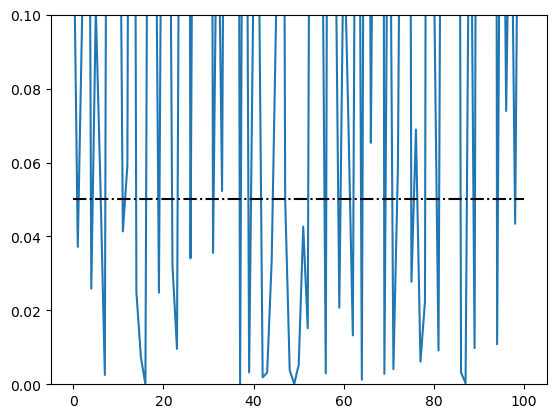

In [ ]:
plt.plot(pvals)
plt.hlines(0.05, 0, 100, 'k', ls='-.')
plt.ylim(0, 0.1)
print((np.array(pvals) <= 0.05).sum())

In [ ]:
df['n_cups'].value_counts()

0    109
2     38
1     32
3     12
4      5
5      2
6      1
7      1
Name: n_cups, dtype: int64

In [ ]:
df['n_dt'].value_counts()

0    88
1    86
2    14
3     7
6     2
5     2
4     1
Name: n_dt, dtype: int64

In [ ]:
pc

0    0.545
1    0.160
2    0.190
3    0.060
4    0.025
5    0.010
6    0.005
7    0.005
Name: n_cups, dtype: float64

In [ ]:
# apple, cup, knife, banana
[[0, 1, 3, 4, 0, 0, 5, 6, 0]
 [0, 1, 3, 4, 0, 0, 5, 6, 0]]